# TTACH Library

In [11]:
import ttach as tta

import os
import json
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
import seaborn as sns
from torchvision import models
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix


In [12]:
class CassavaDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"])
        image = Image.open(img_path).convert("RGB")
        label = int(row["label"])
        if self.transform:
            image = self.transform(image)
        return image, label


class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, csv_path, json_path, transform, batch_size=64, num_workers=2):
        super().__init__()
        self.data_dir = data_dir
        self.csv_path = csv_path
        self.json_path = json_path
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Transforms (standard ImageNet normalization)
        self.val_transform = transforms.Compose([
            transforms.Resize(256),               # Resize smaller edge to 256 (keeps aspect ratio)
            transforms.CenterCrop(224),           # Crop the center 224x224 region
            transforms.ToTensor(),                # Convert to tensor (HWC → CHW, scales to [0,1])
            transforms.Normalize(                 # Normalize with ImageNet mean and std
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        self.train_transform = transform


    def setup(self, stage=None):
        # Load metadata
        df = pd.read_csv(self.csv_path)
        with open(self.json_path, "r") as f:
            self.class_mapping = json.load(f)

        # Split according to 'set' column
        train_df = df[df["set"] == "train"]
        val_df = df[df["set"] == "val"]
        test_df = df[df["set"] == "test"]

        # Create datasets
        self.train_ds = CassavaDataset(train_df, os.path.join(self.data_dir, "images"), transform=self.train_transform)
        self.val_ds = CassavaDataset(val_df, os.path.join(self.data_dir, "images"), transform=self.val_transform)
        self.test_ds = CassavaDataset(test_df, os.path.join(self.data_dir, "images"), transform=self.val_transform)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import pytorch_lightning as pl


class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0.):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd

        # TorchMetrics solo funciona con etiquetas enteras, así que
        # guardamos también una métrica manual cuando haya MixUp/CutMix
        self.train_acc_metric = torchmetrics.classification.Accuracy(
            task="multiclass", num_classes=5
        )
        self.val_acc_metric = torchmetrics.classification.Accuracy(
            task="multiclass", num_classes=5
        )

    # ==========================================================
    #  Forward
    # ==========================================================
    def forward(self, x):
        return self.model(x)

    # ==========================================================
    #  Optimizer
    # ==========================================================
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)

    # ==========================================================
    #  Training step (compatible con MixUp / CutMix)
    # ==========================================================
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        # --- Caso MixUp/CutMix: etiquetas one-hot o soft ---
        if y.ndim == 2:
            # Cross-entropy “soft”: -sum(y * log_softmax)
            loss = torch.sum(-y * F.log_softmax(logits, dim=1), dim=1).mean()

            # Accuracy: comparar predicciones con argmax de las etiquetas soft
            preds = torch.argmax(logits, dim=1)
            acc = (preds == torch.argmax(y, dim=1)).float().mean()
        else:
            # --- Caso normal ---
            loss = F.cross_entropy(logits, y)
            preds = torch.argmax(logits, dim=1)
            acc = self.train_acc_metric(preds, y)

        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    # ==========================================================
    #  Validation step (compatible con MixUp / CutMix)
    # ==========================================================
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        if y.ndim == 2:
            loss = torch.sum(-y * F.log_softmax(logits, dim=1), dim=1).mean()
            preds = torch.argmax(logits, dim=1)
            acc = (preds == torch.argmax(y, dim=1)).float().mean()
        else:
            loss = F.cross_entropy(logits, y)
            preds = torch.argmax(logits, dim=1)
            acc = self.val_acc_metric(preds, y)

        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss


In [14]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

# Recreate the model architecture
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

# Load from Lightning checkpoint
lightning_module = LightningModule.load_from_checkpoint(
    "transforms/hor_flip/best_valid_loss_ft.ckpt",  # or whichever checkpoint you want
    model=model
)

# Extract the underlying PyTorch model
model = lightning_module.model
model.eval().cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
transform_tta = tta.Compose(
    [
        tta.HorizontalFlip(), 
    ]
)

tta_model = tta.ClassificationTTAWrapper(model, transform_tta, merge_mode='mean')

✅ Test Accuracy with TTA: 0.8112


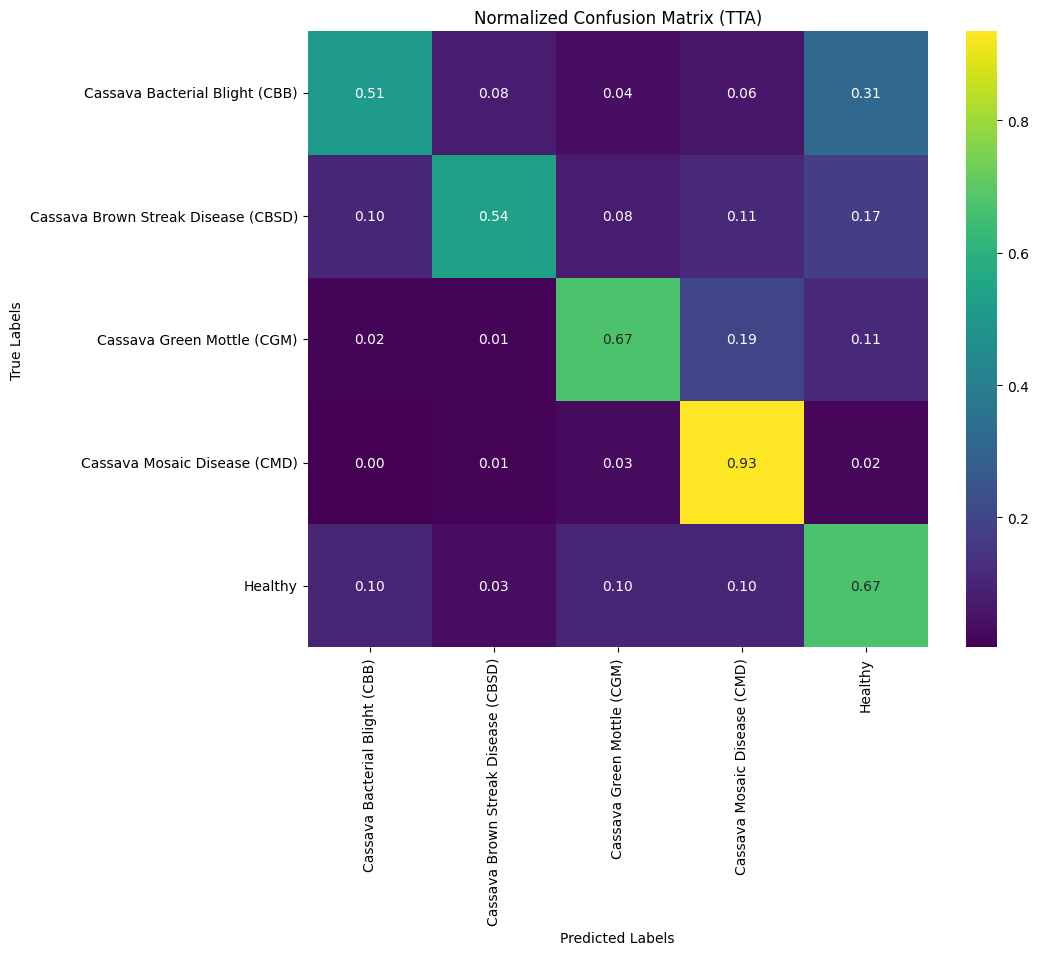

In [16]:
# --- 3️⃣ Prepare data module ---
data_module = CassavaDataModule(
    data_dir="cassava",
    csv_path="cassava/cassava_split.csv",
    json_path="cassava/label_num_to_disease_map.json",
    transform=None,  # not used for test
    batch_size=64
)
data_module.setup("test")

# --- 4️⃣ Evaluate on the full test set ---
y_trues, y_hats = [], []

with torch.no_grad():
    for x, y_true in data_module.test_dataloader():
        x = x.cuda()
        # TTA model automatically applies all transforms and averages predictions
        y_hat_logits = tta_model(x)
        y_hat = torch.argmax(y_hat_logits, dim=1).cpu()

        y_trues.append(y_true)
        y_hats.append(y_hat)

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

# --- 5️⃣ Compute metrics ---
acc = accuracy_score(y_trues, y_hats)
print(f"✅ Test Accuracy with TTA: {acc:.4f}")

# --- 6️⃣ Confusion matrix ---
class_labels = list(data_module.class_mapping.values())

cm = confusion_matrix(
    y_trues,
    y_hats,
    labels=range(len(class_labels)),
    normalize="true"
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("Normalized Confusion Matrix (TTA)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

✅ Accuracy without TTA: 0.8053
✅ Accuracy with TTA: 0.8112


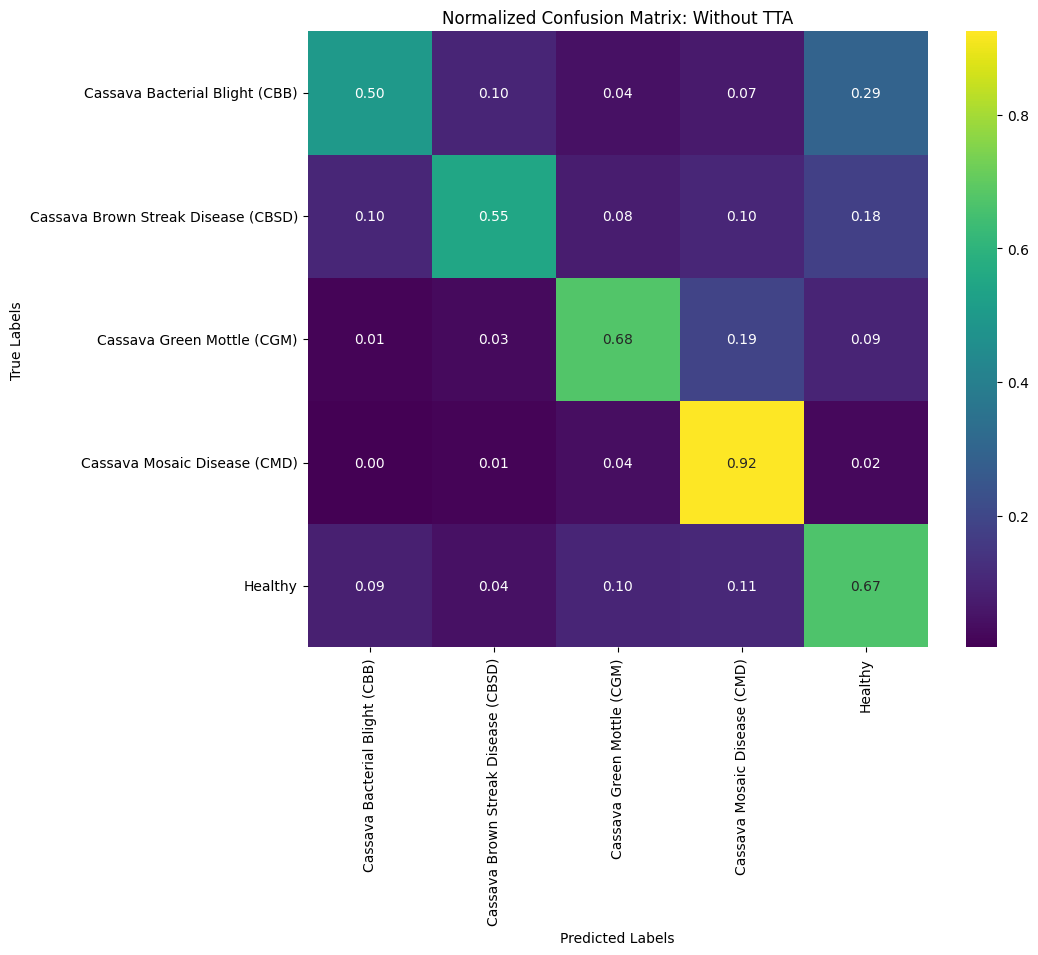

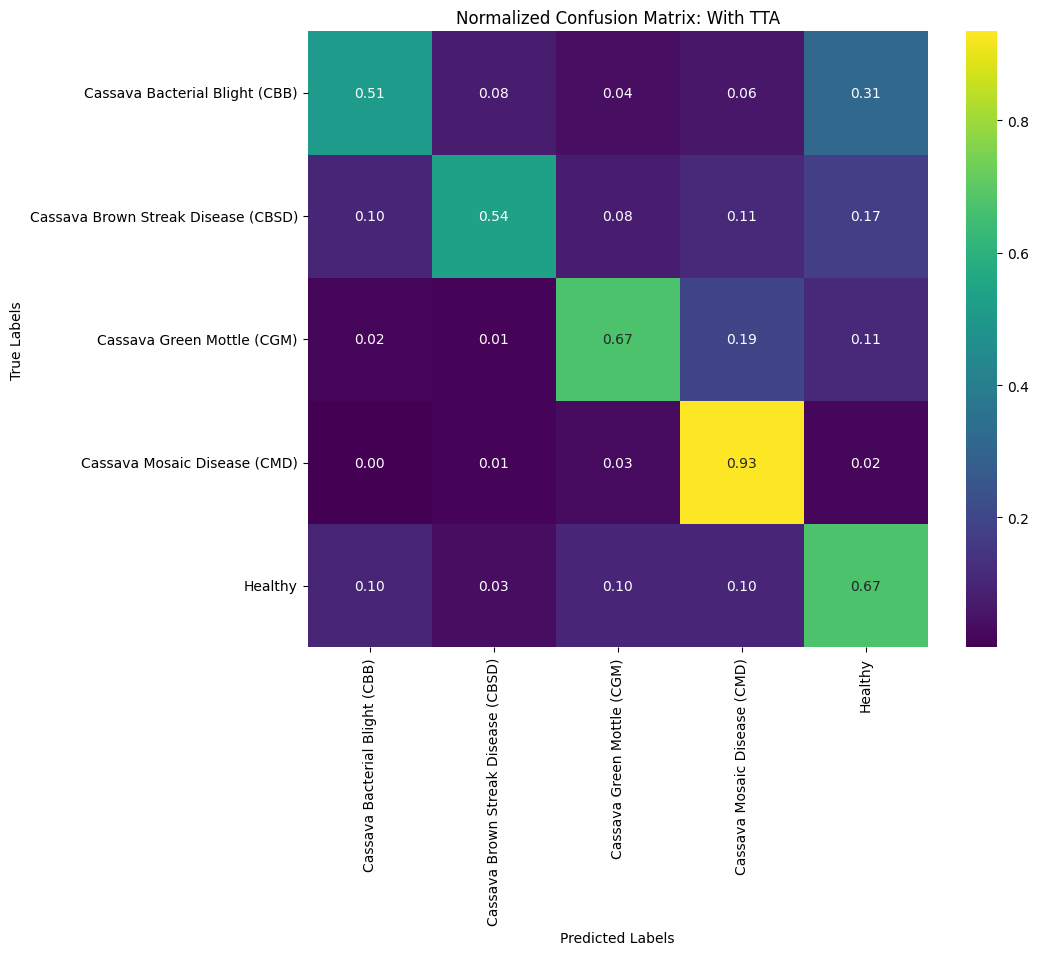

In [18]:
# --- 4️⃣ Define a function for evaluation ---
def evaluate_model(model_to_use, dataloader):
    y_trues, y_hats = [], []

    with torch.no_grad():
        for x, y_true in dataloader:
            x = x.cuda()
            y_hat_logits = model_to_use(x)
            y_hat = torch.argmax(y_hat_logits, dim=1).cpu()

            y_trues.append(y_true)
            y_hats.append(y_hat)

    y_trues = torch.cat(y_trues)
    y_hats = torch.cat(y_hats)

    acc = accuracy_score(y_trues, y_hats)
    return y_trues, y_hats, acc

# --- 5️⃣ Evaluate without TTA ---
y_trues, y_hats, acc_no_tta = evaluate_model(model, data_module.test_dataloader())
print(f"✅ Accuracy without TTA: {acc_no_tta:.4f}")

# --- 6️⃣ Evaluate with TTA ---
y_trues_tta, y_hats_tta, acc_tta = evaluate_model(tta_model, data_module.test_dataloader())
print(f"✅ Accuracy with TTA: {acc_tta:.4f}")

# --- 7️⃣ Confusion matrices ---
class_labels = list(data_module.class_mapping.values())

for name, y_pred in [("Without TTA", y_hats), ("With TTA", y_hats_tta)]:
    cm = confusion_matrix(y_trues, y_pred, labels=range(len(class_labels)), normalize="true")
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Normalized Confusion Matrix: {name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
